In [31]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

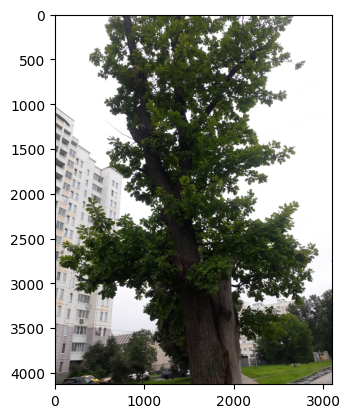

In [32]:
# --- 1. Загрузка изображения ---
image = cv2.imread("images/oak_tree.jpg")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [33]:
from TreeDetection import TreeDetector


0: 640x480 1 tree, 24.0ms
Speed: 15.8ms preprocess, 24.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


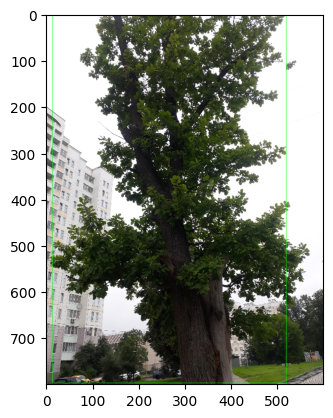

In [34]:
detector = TreeDetector()
boxes, classes = detector.bboxes(image)

plt.imshow(cv2.cvtColor(detector.visualize_boxes(image, boxes, classes), cv2.COLOR_BGR2RGB))

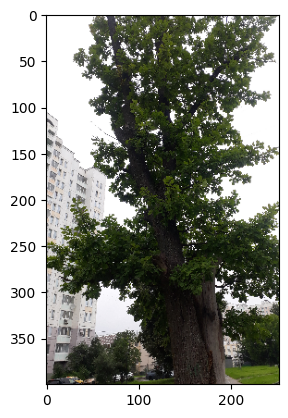

In [35]:
for i, box in enumerate(boxes):
    x1, y1, x2, y2, conf, cls_id = box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    # Вырезаем
    cropped = image[y1:y2, x1:x2]

    height, width = cropped.shape[:2]
    max_display_size = 400
    if max(height, width) > max_display_size:
        scale = max_display_size / max(height, width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        cropped = cv2.resize(cropped, (new_width, new_height))

    # Получаем имя класса
    cls_name = classes.get(int(cls_id), 'unknown')

plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))


In [36]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- 1. Загрузка SAM ---
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# --- 2. Загружаем картинку ---
image_np = np.array(cropped)

# --- 3. Генерация масок ---
masks = mask_generator.generate(image_np)

# Выбираем самую большую маску
mask_areas = [np.sum(m["segmentation"]) for m in masks]
largest_mask_idx = np.argmax(mask_areas)
mask = masks[largest_mask_idx]["segmentation"]

# --- 4. Применяем маску ---
masked_img = image_np.copy()
masked_img[~mask] = 255
masked_pil = Image.fromarray(masked_img)

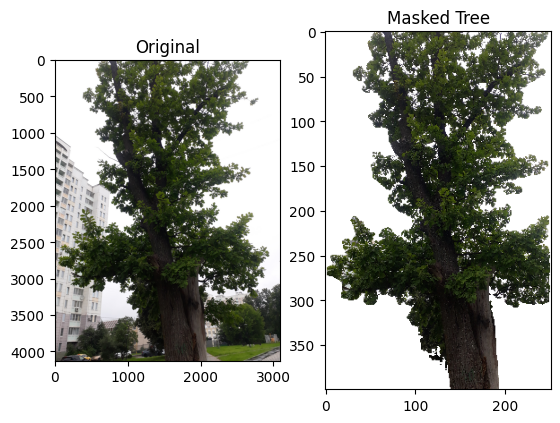

In [37]:
# Визуализация
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Masked Tree")
plt.show()